In [86]:
import copy
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

#################################################################   
####################Physics-Informed Neural Network #############
NUM_EPOCHS = 50000
LEARNING_RATE = 1e-3
NUM_COLLOCATION = 10000
PATIENCE = 1000
THRESHOLD = 1e-3
EARLY_STOPPING_EPOCH = 1
NUM_SAMPLES = 1000

MU = 1.0

T_START = 0.0
T_END = 10.0
dt = 0.5

X1_MIN, X2_MIN = -3.0, -3.0
X1_MAX, X2_MAX = 3.0, 3.0
U_MIN, U_MAX = -1.0, 1.0

In [87]:
def plot_solution(df: pd.DataFrame) -> None:
    # Plot the solution
    plt.figure(figsize=(10, 5))
    plt.plot(df["t"], df["x1"], label="x1(t)")
    plt.plot(df["t"], df["x2"], label="x2(t)")
    ax2 = plt.gca().twinx()
    ax2.plot(df["t"], df["u"], label="u(t)", color='gray', linestyle='--', alpha=0.5)
    ax2.set_ylabel("Control")
    ax2.legend(loc='upper right')
    plt.xlabel("Time")
    plt.ylabel("State")
    plt.title("Van der Pol Oscillator")
    plt.legend()
    plt.grid()
    plt.show()

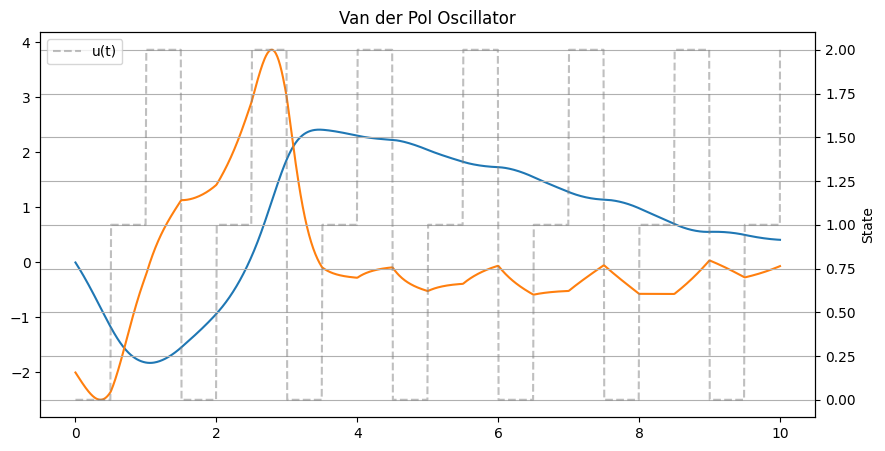

In [88]:
# Define a time-varying control input u(t) as a step function
def control_input(t):
    return np.floor(t / dt) % 3 # Example: alternates between 0 and 1 every dt

# Van der Pol oscillator dynamic system with time-varying u
def vanderpol(t, x, mu=MU):
    u = control_input(t)
    return np.array([x[1], mu * (1 - x[0] ** 2) * x[1] - x[0] + u])

# Solve the system using solve_ivp
sol_varying_u = solve_ivp(
    fun=vanderpol, 
    t_span=(T_START, T_END), 
    y0=[0, -2], 
    args=(MU,), 
    method="RK45", 
    max_step=0.01
)

# Convert the solution to a DataFrame
df = pd.DataFrame(sol_varying_u.y.T, columns=["x1", "x2"])
df["t"] = sol_varying_u.t
df["u"] = df["t"].apply(control_input)

plot_solution(df)

In [36]:
def numpy_to_tensor(array):
    return torch.tensor(array, requires_grad=True, dtype=torch.float32).to(DEVICE).reshape(-1, 1)

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

class PINN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PINN, self).__init__()
        self.input = nn.Linear(input_dim, 20)
        self.fc = nn.Linear(20, 20)
        self.output = nn.Linear(20, output_dim)

    def forward(self, x):
        x = torch.tanh(self.input(x))
        x = torch.tanh(self.fc(x))
        x = torch.tanh(self.fc(x))
        x = self.output(x)
        return x

In [37]:
def generate_dataset(num_samples: int = NUM_SAMPLES):
    """Generate dataset of random multiple initial conditions and control actions"""
    df = pd.DataFrame(columns=['t', 'x1', 'x2', 'u'])
    df['x1'] = np.random.uniform(X1_MIN, X2_MAX, num_samples)
    df['x2'] = np.random.uniform(X2_MIN, X2_MAX, num_samples)
    df['u'] = np.random.uniform(U_MIN, U_MAX, num_samples)
    df['t'] = 0.0 # initial time (always 0)
    
    t_train = numpy_to_tensor(df['t'].values)
    X1_train = numpy_to_tensor(df['x1'].values)
    X2_train = numpy_to_tensor(df['x2'].values)
    U_train = numpy_to_tensor(df['u'].values)
    
    in_train = torch.cat([t_train, X1_train, X2_train, U_train], dim=1)
    out_train = torch.cat([X1_train, X2_train], dim=1)
    
    return in_train, out_train


def loss_fn(net: nn.Module) -> torch.Tensor:
    t_col = numpy_to_tensor(np.random.uniform(T_START, dt, NUM_COLLOCATION))
    X1_col = numpy_to_tensor(np.random.uniform(X1_MIN, X2_MAX, NUM_COLLOCATION))
    X2_col = numpy_to_tensor(np.random.uniform(X2_MIN, X2_MAX, NUM_COLLOCATION))
    U_COL = numpy_to_tensor(np.random.uniform(U_MIN, U_MAX, NUM_COLLOCATION))
    
    u_col = torch.cat([t_col, X1_col, X2_col, U_COL], dim=1)

    preds = net.forward(u_col)

    X1_pred = preds[:, 0].view(-1, 1)
    X2_pred = preds[:, 1].view(-1, 1)
    
    dX1dt_pred = grad(X1_pred, t_col)[0]
    dX2dt_pred = grad(X2_pred, t_col)[0]

    error_dX1dt = dX1dt_pred - X2_pred
    error_dX2dt = dX2dt_pred - MU * (1 - X1_pred ** 2) * X2_pred - X1_pred + U_COL
    
    error_ode = (torch.mean(error_dX1dt ** 2) + torch.mean(error_dX2dt ** 2)) / 2
    
    
    return error_ode

In [38]:
in_train, out_train = generate_dataset()

print(f'Input shape: {in_train.shape}')
print(f'Output shape: {out_train.shape}')

Input shape: torch.Size([1000, 4])
Output shape: torch.Size([1000, 2])


In [ ]:
# Main
net = PINN(input_dim=in_train.shape[1], output_dim=out_train.shape[1]).to(DEVICE)
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.7)

# Loss weights
w_data, w_ode, w_ic = 1.0, 1.0, 1.0

# Initialize early stopping variables
best_loss = float("inf")
best_model_weights = None
patience = PATIENCE
threshold = THRESHOLD

for epoch in tqdm(range(NUM_EPOCHS)):
    optimizer.zero_grad()
    preds = net.forward(in_train)
    X1_pred = preds[:, 0].view(-1, 1)
    X2_pred = preds[:, 1].view(-1, 1)
    loss_data = (torch.mean((X1_pred - out_train[:, 0].view(-1, 1))**2) + torch.mean((X2_pred - out_train[:, 1].view(-1, 1))**2)) / 2
    loss_ode = loss_fn(net)
    loss = w_data * loss_data + w_ode * loss_ode
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4e}, Data Loss = {loss_data.item():.4e}, ODE Loss = {loss_ode.item():.4e}")
    # Early stopping
    if loss.item() < best_loss - threshold:
        best_loss = loss.item()
        best_model_weights = copy.deepcopy(net.state_dict())
        patience = PATIENCE
    else:
        patience -= 1
        if patience <= 0:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model weights
if best_model_weights is not None:
    net.load_state_dict(best_model_weights)
    net.eval()
    print("Loaded best model weights.")
else:
    print("No model weights to load.")
    net.eval()

# Save the model
torch.save(net.state_dict(), 'pinn_model_paper.pth')

  0%|          | 42/50000 [00:00<04:03, 205.44it/s]

Epoch 0: Loss = 3.1335e+00, Data Loss = 2.8987e+00, ODE Loss = 2.3474e-01


  2%|▏         | 1041/50000 [00:04<02:55, 279.44it/s]

Epoch 1000: Loss = 1.1012e-01, Data Loss = 5.7629e-02, ODE Loss = 5.2490e-02


  4%|▍         | 2030/50000 [00:07<02:53, 276.17it/s]

Epoch 2000: Loss = 3.8079e-02, Data Loss = 1.9675e-02, ODE Loss = 1.8404e-02


  6%|▌         | 3042/50000 [00:11<02:53, 270.88it/s]

Epoch 3000: Loss = 2.5301e-02, Data Loss = 1.2197e-02, ODE Loss = 1.3104e-02


  8%|▊         | 4034/50000 [00:14<02:48, 273.05it/s]

Epoch 4000: Loss = 1.7568e-02, Data Loss = 7.8074e-03, ODE Loss = 9.7604e-03


 10%|█         | 5054/50000 [00:18<02:43, 275.48it/s]

Epoch 5000: Loss = 1.2488e-02, Data Loss = 4.9792e-03, ODE Loss = 7.5085e-03


 12%|█▏        | 6053/50000 [00:22<02:39, 276.01it/s]

Epoch 6000: Loss = 1.0077e-02, Data Loss = 3.5019e-03, ODE Loss = 6.5756e-03


 14%|█▍        | 7046/50000 [00:25<02:32, 281.12it/s]

Epoch 7000: Loss = 7.2704e-03, Data Loss = 2.4833e-03, ODE Loss = 4.7872e-03


 16%|█▌        | 8031/50000 [00:29<02:30, 278.18it/s]

Epoch 8000: Loss = 6.4063e-03, Data Loss = 2.0017e-03, ODE Loss = 4.4046e-03


 17%|█▋        | 8682/50000 [00:31<02:31, 272.89it/s]

Early stopping at epoch 8682
Loaded best model weights.


In [81]:
T_s = 0.5
t_test = numpy_to_tensor(np.array([df['t'].values]))
x1_test = numpy_to_tensor(np.array([df['x1'].values]))
x2_test = numpy_to_tensor(np.array([df['x2'].values]))
u_test = numpy_to_tensor(np.array([df['u'].values]))
in_test = torch.cat([t_test, x1_test, x2_test, u_test], dim=1)
out_test = torch.cat([x1_test, x2_test], dim=1)

x1_0 = x1_test[0]
x2_0 = x2_test[0]
u_0 = u_test[0]

x1_preds = []
x2_preds = []

for i in range(len(df)):
    if i == 0:
        x1_preds.append(x1_0.item())
        x2_preds.append(x2_0.item())
        continue
    
    x_k = net.forward(torch.tensor([T_s, x1_0, x2_0, u_0], dtype=torch.float32).to(DEVICE))
    x1_0 = x1_test[i]
    x2_0 = x2_test[i]
    u_0 = u_test[i]
    x1_preds.append(x_k[0].item())
    x2_preds.append(x_k[1].item())
    

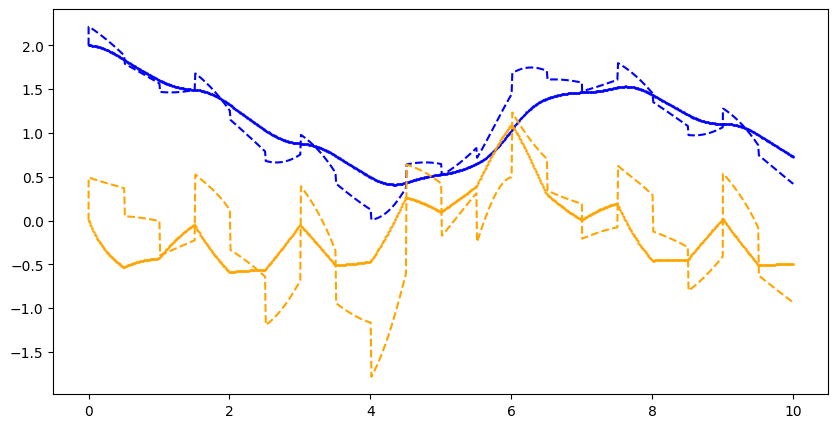

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df['t'], df['x1'], label="x1(t)", color='blue', s=0.5)
plt.scatter(df['t'], df['x2'], label="x2(t)", color='orange', s=0.5)

plt.plot(t_test.detach().cpu().numpy(), x1_preds, label="x1_pred(t)", color='blue', linestyle='--')
plt.plot(t_test.detach().cpu().numpy(), x2_preds, label="x2_pred(t)", color='orange', linestyle='--')

